# Jupyter Notebook - Stock History Virtualization
Version: 2018-12-24

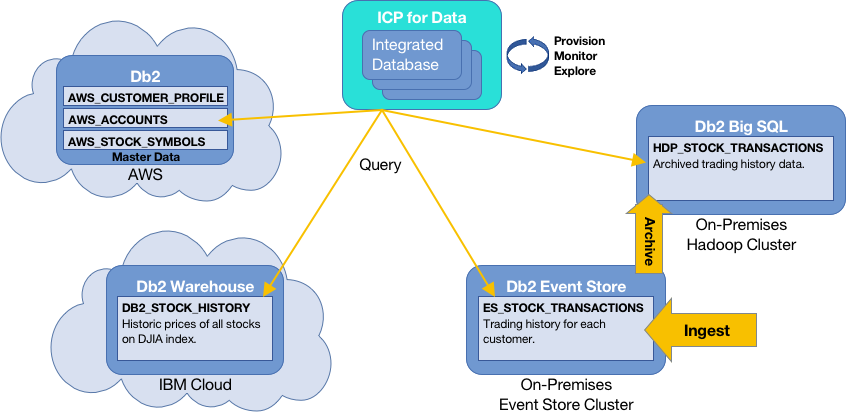

<p><br/></p>
<table>
    <tr><th>TABLE</th><th>PK</th><th>SK</th>
    <tr><td>AWS_ACCOUNTS</td><td>CUSTID</td><td></td>
    <tr><td>AWS_CUSTOMER_PROFILE</td><td>CUSTID</td><td></td>
    <tr><td>AWS_STOCK_SYMBOLS</td><td>SYMBOL</td><td></td>
    <tr><td>DB2_STOCK_HISTORY</td><td>SYMBOL</td><td></td>
    <tr><td>ES_STOCK_TRANSACTIONS</td><td>CUSTID</td><td>SYMBOL</td>
    <tr><td>HDP_STOCK_TRANSACTIONS_HISTORY</td><td>CUSTID</td><td>SYMBOL</td>
    <tr><td>JV-AWS_CUSTOMER_PROFILE-ES_STOCK_TRANSACTIONS</td><td>CUSTID</td><td>SYMBOL</td>
    <tr><td>JV-AWS_ACCOUNTS-HDP_STOCK_TRANSACTIONS</td><td>CUSTID</td><td>SYMBOL</td>
<table>

> Note:
- The list of available tables in the Project and their available keys to join. The tables starting with JV are virtual join tables where two or more virtual tables have been joined together.

## Simple Query with 1 Virtual Table (1 Db2)
#### Retrieve all of the user accounts 

```SQL
SELECT * FROM 'USER999.AWS_ACCOUNTS'
```

> Note: The USER999.AWS_ACCOUNTS dataset is a virtual table mapped to the STOCKS.AWS_ACCOUNTS table running on a Db2 instance running on AWS

In [ ]:
import dsx_core_utils, requests, jaydebeapi, os, io, sys
from pyspark.sql import SparkSession
import pandas as pd

df = None
dataSet = dsx_core_utils.get_remote_data_set_info('USER999.AWS_ACCOUNTS')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
if (sys.version_info >= (3, 0)):
  conn = jaydebeapi.connect(dataSource['driver_class'], dataSource['URL'], [dataSource['user'], dataSource['password']])
else:
  conn = jaydebeapi.connect(dataSource['driver_class'], [dataSource['URL'], dataSource['user'], dataSource['password']])
query = 'select * from "' + (dataSet['schema'] + '"."' if (len(dataSet['schema'].strip()) != 0) else '') +  dataSet['table'] + '"'

if (dataSet['query']):
    query = dataSet['query']
df = pd.read_sql(query, con=conn)
df.head()

## Simple Query with 1 Join View Virtual Table (1 Db2 and 1 Event Store)
#### Retrieve all of the customer profiles and their stock transactions for the current year

```SQL
SELECT * FROM 'USER999.JV-AWS_CUSTOMER_PROFILE-ES_STOCK_TRANSACTIONS'
```

> Note: If you recall, we created this Join View table in the *Virtualized data* section of IBM Cloud Private for Data.

In [2]:
df = None
dataSet = dsx_core_utils.get_remote_data_set_info('USER999.JV-AWS_CUSTOMER_PROFILE-ES_STOCK_TRANSACTIONS')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
if (sys.version_info >= (3, 0)):
  conn = jaydebeapi.connect(dataSource['driver_class'], dataSource['URL'], [dataSource['user'], dataSource['password']])
else:
  conn = jaydebeapi.connect(dataSource['driver_class'], [dataSource['URL'], dataSource['user'], dataSource['password']])
query = 'select * from "' + (dataSet['schema'] + '"."' if (len(dataSet['schema'].strip()) != 0) else '') +  dataSet['table'] + '"'

if (dataSet['query']):
    query = dataSet['query']
df = pd.read_sql(query, con=conn)
df.head()


,CUSTID,EMAIL,STREET,ZIPCODE,CARD_TYPE,CITY,BIRTHDATE,FIRSTNAME,LASTNAME,PHONE,STATE,PRICE,QUANTITY,SYMBOL,TX_DATE,TX_NO
0,104197,Li.Harrison@giggle.com,Grant Street,90801,PKUP,Long Beach,1988-04-29,Linda,Harrison,534-729-4992,CA,235.26,15,com.ibm.db2.jcc.am.ye@2f8f5f62,2018-05-02,185141
1,101950,G.Clayton@nada.com,2nd Avenue,87401,CASH,Farmington,1960-07-15,Gary,Clayton,679-340-6475,NM,99.83,-70,com.ibm.db2.jcc.am.ye@1068e947,2018-05-02,185142
2,104649,Kathlee.Bray@giggle.com,Essex Court,68701,PKUP,Norfolk,1977-06-14,Kathleen,Bray,716-296-3824,NE,127.38,23,com.ibm.db2.jcc.am.ye@7dc222ae,2018-05-02,185143
3,107022,Ra.Nixon@nada.com,High Street,44001,VASA,Amherst,1967-02-14,Ralph,Nixon,477-660-6295,OH,86.48,71,com.ibm.db2.jcc.am.ye@aecb35a,2018-05-02,185144
4,100798,Gregor.Schneider@hatmail.com,11th Street,63801,MCCD,Sikeston,1985-10-20,Gregory,Schneider,216-859-5658,MO,235.10,6,com.ibm.db2.jcc.am.ye@5fcd892a,2018-05-02,185145


## Complex Query with 1 Virtual Table (1 Db2) plus Plotting
#### Compare Apple's historical opening price to its moving average by transactions date

```SQL
SELECT TX_DATE, OPENING, 
     AVG(OPENING) OVER (
       ORDER BY TX_DATE
     ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING) AS MOVING_AVG
  FROM USER999.DB2_STOCK_HISTORY
     WHERE SYMBOL = 'AAPL'
  ORDER BY TX_DATE
```

Process:
1. Import the MATLAB library for plotting
2. Get Apple's opening price and moving average by transaction date
3. Parse the resulting dataset into 3 variables for plotting
4. Plot the transaction date and opening price in RED
5. Plot the transaction date and moving average in BLUE

In [3]:
import matplotlib
import matplotlib.pyplot as plt

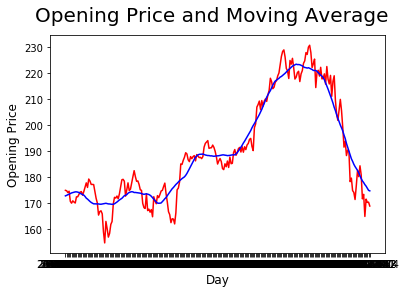

In [4]:
df = None
dataSet = dsx_core_utils.get_remote_data_set_info('USER999.DB2_STOCK_HISTORY')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
if (sys.version_info >= (3, 0)):
  conn = jaydebeapi.connect(dataSource['driver_class'], dataSource['URL'], [dataSource['user'], dataSource['password']])
else:
  conn = jaydebeapi.connect(dataSource['driver_class'], [dataSource['URL'], dataSource['user'], dataSource['password']])
#query = 'select * from "' + (dataSet['schema'] + '"."' if (len(dataSet['schema'].strip()) != 0) else '') +  dataSet['table'] + '"'
query = \
"""
SELECT TX_DATE, OPENING, 
     AVG(OPENING) OVER (
       ORDER BY TX_DATE
     ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING) AS MOVING_AVG
  FROM USER999.DB2_STOCK_HISTORY
     WHERE SYMBOL = 'AAPL'
  ORDER BY TX_DATE
"""


if (dataSet['query']):
    query = dataSet['query']
df = pd.read_sql(query, con=conn)
txdate= df['TX_DATE']
opening = df['OPENING']
avg = df['MOVING_AVG']

plt.xlabel("Day", fontsize=12);
plt.ylabel("Opening Price", fontsize=12);
plt.suptitle("Opening Price and Moving Average", fontsize=20);
plt.plot(txdate, opening, 'r');
plt.plot(txdate, avg, 'b');
plt.show();

## Simple Query Joining 2 Virtual Tables (1 Db2 and 1 Hadoop)
#### This query will join the CUSTID key on two tables return the historical stock transactions for a specific customer ordered by the largest quantity

```SQL
SELECT A.CUSTID, STH.TX_DATE, STH.SYMBOL, STH.PRICE, STH.QUANTITY
  FROM AWS_ACCOUNTS A
    INNER JOIN HDP_STOCK_TRANSACTIONS_HISTORY STH
      ON A.CUSTID = STH.CUSTID
  WHERE A.CUSTID = 108277
    ORDER BY STH.QUANTITY DESC
```

In [5]:
df = None
dataSet = dsx_core_utils.get_remote_data_set_info('USER999.AWS_ACCOUNTS')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
if (sys.version_info >= (3, 0)):
  conn = jaydebeapi.connect(dataSource['driver_class'], dataSource['URL'], [dataSource['user'], dataSource['password']])
else:
  conn = jaydebeapi.connect(dataSource['driver_class'], [dataSource['URL'], dataSource['user'], dataSource['password']])
#query = 'select * from "' + (dataSet['schema'] + '"."' if (len(dataSet['schema'].strip()) != 0) else '') +  dataSet['table'] + '"'
query = \
"""
SELECT A.CUSTID, STH.TX_DATE, STH.SYMBOL, STH.PRICE, STH.QUANTITY
  FROM AWS_ACCOUNTS A
    INNER JOIN HDP_STOCK_TRANSACTIONS STH
      ON A.CUSTID = STH.CUSTID
  WHERE A.CUSTID = 108277
    ORDER BY STH.QUANTITY DESC
"""

if (dataSet['query']):
    query = dataSet['query']
df = pd.read_sql(query, con=conn)
df.head()

,CUSTID,TX_DATE,SYMBOL,PRICE,QUANTITY
0,108277,2017-08-08,KO,46.0,86
1,108277,2017-03-21,PFE,35.0,85
2,108277,2017-10-06,XOM,81.0,72
3,108277,2017-01-25,DWDP,60.0,69
4,108277,2017-03-06,MRK,67.0,65


## Complex Query with Multiple Joins using 5 Virtual Tables (3 Db2, 1 Event Store, 1 Hadoop)
#### A series of queries to get the name of all customers in California who purchased the top three stocks by volume in October 2018 and also bought the same stocks in the prior year (October 2017) and currently have a balance in their portfolio. List the customer name and the stock.
```SQL
SELECT C.LASTNAME, P2018.SYMBOL
  FROM PURCHASES_2018 P2018, PURCHASES_2017 P2017, CUSTOMERS_IN_CA C
    WHERE C.CUSTID = P2017.CUSTID AND
      C.CUSTID = P2018.CUSTID AND
      P2017.SYMBOL = P2018.SYMBOL
    ORDER BY 1,2
```
Process:
1. Get the list of customers from California and their lastname and check to see if they have a balance > 0 and add the results to the new **CUSTOMERS_IN_CA** table
2. Get the highest 3 stocks in the DJIA by for the month of October and add the results to the new **TOP_STOCKS** table
3. Get the transactions in the month of October 2018 made by the customers in step #2 and add the results to the new **PURCHASES_2018** table
4. Get the transactions in the month of October 2017 made by the customers in step #2 and add the results to the new **PURCHASES_2017** table
5. Make sure that customer exists in **PURCHASES_2018** #3 and **PURCHASES_2017** #4 and display the customer's last name and the stock symbol ordered by last name, symbol

In [6]:
df = None
dataSet = dsx_core_utils.get_remote_data_set_info('USER999.AWS_ACCOUNTS')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
if (sys.version_info >= (3, 0)):
  conn = jaydebeapi.connect(dataSource['driver_class'], dataSource['URL'], [dataSource['user'], dataSource['password']])
else:
  conn = jaydebeapi.connect(dataSource['driver_class'], [dataSource['URL'], dataSource['user'], dataSource['password']])
#query = 'select * from "' + (dataSet['schema'] + '"."' if (len(dataSet['schema'].strip()) != 0) else '') +  dataSet['table'] + '"'
query = \
"""
WITH 
CUSTOMERS_IN_CA(CUSTID, LASTNAME) AS
  (
  SELECT P.CUSTID, P.LASTNAME
  FROM AWS_CUSTOMER_PROFILE P, AWS_ACCOUNTS A
  WHERE P.STATE = 'CA' AND 
        A.BALANCE > 0 AND
        A.CUSTID = P.CUSTID
  ),
TOP_STOCKS(SYMBOL, VOLUME) AS 
  (
  SELECT SYMBOL, MAX(VOLUME) 
  FROM DB2_STOCK_HISTORY
  WHERE SYMBOL <> 'DJIA' AND MONTH(TX_DATE) = 10
  GROUP BY SYMBOL
  ORDER BY 2 ASC
  FETCH FIRST 3 ROWS ONLY
  ),
PURCHASES_2018(CUSTID, SYMBOL) AS
  (
  SELECT UNIQUE CUSTID, CAST(SYMBOL AS VARCHAR(4))SYMBOL
  FROM ES_STOCK_TRANSACTIONS ES
  WHERE MONTH(ES.TX_DATE) = 10 AND
        ES.CUSTID IN (SELECT CUSTID FROM CUSTOMERS_IN_CA) AND
        ES.SYMBOL IN (SELECT SYMBOL FROM TOP_STOCKS) AND
        ES.QUANTITY > 0
  ),
PURCHASES_2017(CUSTID, SYMBOL) AS
  (
  SELECT UNIQUE CUSTID, SYMBOL
  FROM HDP_STOCK_TRANSACTIONS SH
  WHERE SH.CUSTID IN (SELECT CUSTID FROM CUSTOMERS_IN_CA) AND
        SH.SYMBOL IN (SELECT SYMBOL FROM TOP_STOCKS) AND
        SH.QUANTITY > 0
  )
SELECT C.LASTNAME, P2018.SYMBOL
FROM PURCHASES_2018 P2018, PURCHASES_2017 P2017, CUSTOMERS_IN_CA C
WHERE C.CUSTID = P2017.CUSTID AND
      C.CUSTID = P2018.CUSTID AND
      P2017.SYMBOL = P2018.SYMBOL
ORDER BY 1,2
"""

if (dataSet['query']):
    query = dataSet['query']
df = pd.read_sql(query, con=conn)
df.head()

,LASTNAME,SYMBOL
0,Ayers,AXP
1,Bonner,AXP
2,Case,AXP
3,Collins,GS
4,Collins,GS


In [7]:
import dsx_core_utils,requests, jaydebeapi, os, io, sys
from pyspark.sql import SparkSession
import pandas as pd

df1 = None
dataSet = dsx_core_utils.get_remote_data_set_info('USER999.AWS_ACCOUNTS')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
if (sys.version_info >= (3, 0)):
  conn = jaydebeapi.connect(dataSource['driver_class'], dataSource['URL'], [dataSource['user'], dataSource['password']])
else:
  conn = jaydebeapi.connect(dataSource['driver_class'], [dataSource['URL'], dataSource['user'], dataSource['password']])
query = 'select * from "' + (dataSet['schema'] + '"."' if (len(dataSet['schema'].strip()) != 0) else '') +  dataSet['table'] + '"'
if (dataSet['query']):
    query = dataSet['query']
df1 = pd.read_sql(query, con=conn)
df1.head()

,CUSTID,TX_COUNT,BALANCE
0,100000,48,10036.56
1,100001,63,-17543.91
2,100002,60,8204.60
3,100003,71,9241.59
4,100004,60,1063.10
